# Предсказание уровня удовлетворенности и оттока сотрудника.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Постановка задач:

-  построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:

- Загрузка данных;
- Предобработка данных
- Исследовательский анализ данных
- Подготовка данных
- Обучение моделей
- Вывод и рекоминдации

# Задача №1

In [1]:
!pip install scikit_learn==1.1.3 -q
!pip install --upgrade pip -q
!pip install scikit-learn==1.3.2 -q
!pip install phik -q
!pip install shap==0.44.1 -q
!pip install optuna -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
#Импортируем необходимые библиотеки и инструменты
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import phik
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, RobustScaler) 
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, confusion_matrix,
                             recall_score, precision_score, accuracy_score, roc_auc_score, make_scorer, f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Откроем датасеты и сохраим в переменные.

In [3]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2212,509696,technology,middle,low,5,no,no,3,33600,0.50
1377,956391,technology,junior,low,1,no,no,2,14400,0.24
2655,598548,sales,junior,low,1,no,no,3,14400,0.20
2636,338733,sales,middle,high,7,no,no,4,52800,0.95
3891,517136,purchasing,junior,medium,2,no,no,4,22800,0.74


In [4]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1967,710710,purchasing,middle,low,9,no,no,5,25200
1596,689738,sales,middle,low,3,no,no,4,24000
1016,173430,purchasing,middle,high,5,no,no,4,58800
1787,656468,marketing,middle,high,8,no,no,3,55200
1309,877286,sales,junior,medium,2,no,no,4,28800


In [5]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.sample(5)

,id,job_satisfaction_rate
777,332286,0.69
245,788782,0.50
13,120724,0.79
1200,353936,0.58
1078,879098,0.45


### Промежуточный выводк разделу

Произвели загрузку данных из локальных дисков:

- datasets/train_job_satisfaction_rate.csv
- datasets/test_features.csv
- datasets/test_target_job_satisfaction_rate.csv

На первый взгляд наименование столбцов корректно, приведены к нижнему змеиному регистру.

Исходя из приложенной документации опишем признаки:

- id — уникальный идентификатор сотрудника;

- dept — отдел, в котором работает сотрудник;

- level — уровень занимаемой должности;

- workload — уровень загруженности сотрудника;

- employment_years — длительность работы в компании (в годах);

- last_year_promo — показывает, было ли повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

- salary — ежемесячная зарплата сотрудника;

- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Предобработка данных.

In [6]:
#изучим датасат train_job_satisfaction_rate
print('Размерность датасета:', train_job_satisfaction_rate.shape)
print()
print(train_job_satisfaction_rate.info())
print()
print('Количество дубликатов:', train_job_satisfaction_rate.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', train_job_satisfaction_rate.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', train_job_satisfaction_rate['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',train_job_satisfaction_rate['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',train_job_satisfaction_rate['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',train_job_satisfaction_rate['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',train_job_satisfaction_rate['last_year_promo'].unique())

Размерность датасета: (4000, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id                       0
dept                     6
level                    4
workload               

In [7]:
#взглянем на строки с пропусками в колонке dept
train_job_satisfaction_rate[(train_job_satisfaction_rate['dept'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [8]:
##взглянем на строки с пропусками в колонке level
train_job_satisfaction_rate[(train_job_satisfaction_rate['level'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


#### Промежуточный вывод к train_job_satisfaction_rate

В датасете train_job_satisfaction_rate имеем 10 колонок, 4000 строк.
Явных и неявных дубликатов нет. Наименование колонок корректно.
Имеются пропуски в колонках dept(отдел, в котором работает сотрудник)  -  6шт. 
Колонка level(уровень занимаемой должности)  -  4шт.
Используем метод SimpleImputer с параметром strategy='most_frequent' для заполнения пропусков на этапе создание пайплана.

In [9]:
#изучим датасат test_features
print('Размерность датасета:', test_features.shape)
print()
print(test_features.info())
print()
print('Количество дубликатов:', test_features.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', test_features.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', test_features['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',test_features['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',test_features['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',test_features['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',test_features['last_year_promo'].unique())

Размерность датасета: (2000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violation

In [10]:
#взглянем на строки с пропусками в колонке dept
test_features[(test_features['dept'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [11]:
#взглянем на строки с пропусками в колонке level
test_features[(test_features['level'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [12]:
#взглянем на строки с пробелами в колонке dept
test_features[(test_features['dept'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [13]:
#взглянем на строки с пробелами в колонке workload
test_features[(test_features['workload'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


В колонках dept и workload замечены пробелы. Заменим пробелы на nan, для дальнейшего заполнения методом SimpleImputer.

In [14]:
test_features['workload'].replace(' ', np.nan, inplace=True)
test_features['dept'].replace(' ', np.nan, inplace=True)
print('Уникальные значения колонки "workload":', '\n',test_features['workload'].unique())
print()
print('Уникальные значения колонки "dept":', '\n', test_features['dept'].unique())
print()
print('Количество пропусков в колонках:', '\n', test_features.isna().sum())

Уникальные значения колонки "workload": 
 ['medium' 'low' 'high' nan]

Уникальные значения колонки "dept": 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]

Количество пропусков в колонках: 
 id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


#### Промежуточный вывод к test_features

В датасете test_features имеем 9 колонок, 2000 строк.
Явных и неявных дубликатов нет.  Наименование колонок корректно.
Имеются пропуски в колонках dept(отдел, в котором работает сотрудник)  -  2шт. Колонка level(уровень занимаемой должности)  -  1шт. Используем метод SimpleImputer с параметром strategy='most_frequent' для заполнения пропусков на этапе создание пайплана.



In [15]:
#изучим датасат test_target_job_satisfaction_rate
print('Размерность датасета:', test_target_job_satisfaction_rate.shape)
print()
print(test_target_job_satisfaction_rate.info())
print()
print('Количество дубликатов:', test_target_job_satisfaction_rate.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', test_target_job_satisfaction_rate.isna().sum())
print()

Размерность датасета: (2000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id                       0
job_satisfaction_rate    0
dtype: int64



#### Промежуточный вывод к test_target_job_satisfaction_rate

В датасете test_target_job_satisfaction_rate имеем 2 колонки, 2000 строк.
Явных и неявных дубликатов нет. Пропусков нет. Наименование колонок корректно.

### Промежуточный вывод по разделу:

Были изучены полученные датасеты:

- типы данных в датасетах соответсвуют;

- наименование колонок корректны;

- были замечены пробелы в данных, принято решение заменить их на nan;

- были замечены пропуски в данных, принято решение используя метод SimpleImputer с параметром strategy='most_frequent'  заполнить на этапе создание пайплана;




## Исследовательский анализ данных

Для проведения исследовательсокого анализа соберем все датасеты в один. Объеденим датасеты test_target_job_satisfaction_rate test_features по общей колонке id. Далее добавим поленую таблицу к датасету train_job_satisfaction_rate.

In [16]:
#объеденим датасеты test_features и test_target_job_satisfaction_rate по колонке id
target_features = test_features.merge(test_target_job_satisfaction_rate, on = 'id', how = 'left')

#проверим
print(target_features.head(2))
target_features.info()

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      5   28800                   0.79  
1                   no                      4   30000                   0.72  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year

In [17]:
#добавим к датасету train_job_satisfaction_rate полученный датасет target_features
job_satisfaction_rate_df = pd.concat([train_job_satisfaction_rate, target_features])

#проверим что получилось
print(job_satisfaction_rate_df.head(2))
print()
print('Размерность датасета:', job_satisfaction_rate_df.shape)
print()
print(job_satisfaction_rate_df.info())
print()
print('Количество дубликатов:', job_satisfaction_rate_df.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', job_satisfaction_rate_df.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', job_satisfaction_rate_df['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',job_satisfaction_rate_df['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',job_satisfaction_rate_df['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',job_satisfaction_rate_df['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',job_satisfaction_rate_df['last_year_promo'].unique())

       id   dept   level workload  employment_years last_year_promo  \
0  155278  sales  junior   medium                 2              no   
1  653870     hr  junior     high                 2              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  

Размерность датасета: (6000, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6000 non-null   int64  
 1   dept                   5991 non-null   object 
 2   level                  5995 non-null   object 
 3   workload               5999 non-null   object 
 4   employment_years       6000 non-null   int64  
 5   last_year_promo        6000 non-null  

Объеденение прошло успешно.

In [18]:
#создадим функцию для постраения диаграмм
def boxplot_hist(df, column):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.countplot(df[column])
    print('Описательная статистика признака:', column, '\n', df[column].describe())
    
#создадим функцию для построения круговых графиков категориальных признаков    
def pie_graph(dataframe, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataframe.groupby(column)[name].count(),
            autopct='%1.1f%%',
            labels=dataframe.groupby(column)[name].count().index)

Описательная статистика признака: employment_years 
 count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
Описательная статистика признака: supervisor_evaluation 
 count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
Описательная статистика признака: salary 
 count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64
Описательная статистика признака: job_satisfaction_rate 
 count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000

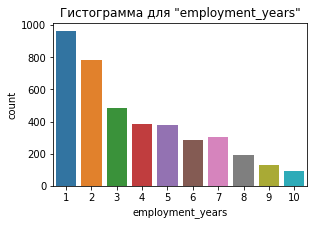

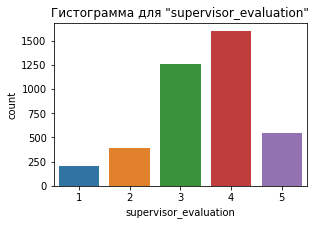

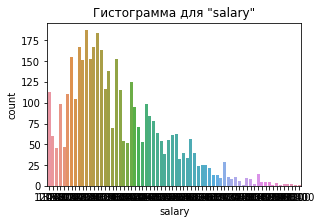

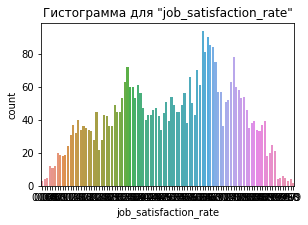

In [19]:
#создадим список наименования столбцов датасета train_job_satisfaction_rate
num_train_job_satisfaction_rate = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary', 
                  'job_satisfaction_rate']

#построение диаграмм датасета train_job_satisfaction_rate
for name in num_train_job_satisfaction_rate:
    boxplot_hist(train_job_satisfaction_rate, name)

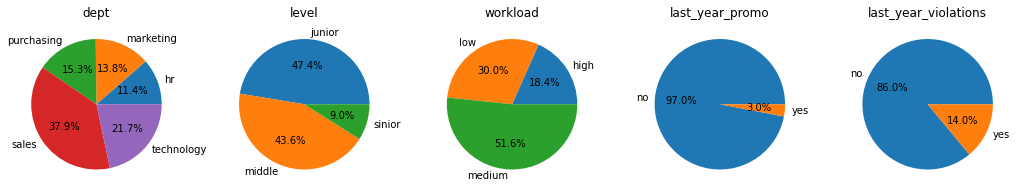

In [20]:
#создадим список наименования столбцов train_job_satisfaction_rate
cat_train_job_satisfaction_rate = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]    

#построение круговых диаграмм train_job_satisfaction_rate
i = 1
plt.figure(figsize=(18,3))
for name in cat_train_job_satisfaction_rate:
    pie_graph(train_job_satisfaction_rate, name, 'id', len(cat_train_job_satisfaction_rate), i)
    i += 1

Описательная статистика признака: employment_years 
 count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
Описательная статистика признака: supervisor_evaluation 
 count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
Описательная статистика признака: salary 
 count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


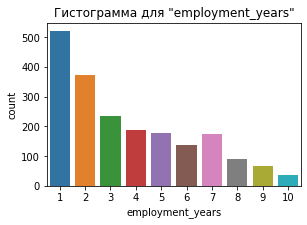

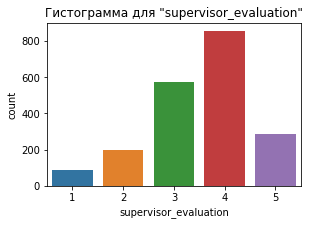

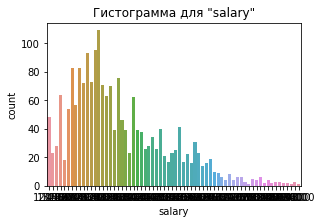

In [21]:
#создадим список наименования столбцов датасета test_features
num_test_features = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary']

#построение диаграмм датасета test_features
for name in num_test_features:
    boxplot_hist(test_features, name)

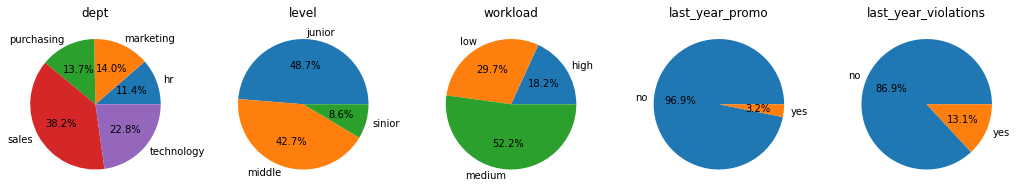

In [22]:
#создадим список наименования столбцов test_features
cat_test_features = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]    

#построение
i = 1
plt.figure(figsize=(18,3))
for name in cat_test_features:
    pie_graph(test_features, name, 'id', len(cat_test_features), i)
    i += 1

In [23]:
test_target_job_satisfaction_rate.head(1)

,id,job_satisfaction_rate
0,130604,0.74


Описательная статистика признака: job_satisfaction_rate 
 count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


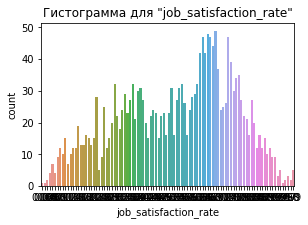

In [24]:
#создадим список наименования столбцов датасета job_satisfaction_rate_df
num_test_target_job_satisfaction_rate = ['job_satisfaction_rate']

#построение
for name in num_test_target_job_satisfaction_rate:
    boxplot_hist(test_target_job_satisfaction_rate, name)

Описательная статистика признака: employment_years 
 count    6000.000000
mean        3.701167
std         2.540658
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
Описательная статистика признака: supervisor_evaluation 
 count    6000.000000
mean        3.493167
std         1.005048
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
Описательная статистика признака: salary 
 count     6000.000000
mean     33973.400000
std      15067.302669
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64
Описательная статистика признака: job_satisfaction_rate 
 count    6000.000000
mean        0.538923
std         0.223692
min         0.030000
25%         0.360000
50%         0.570000
75%         0.710000
max         1.000

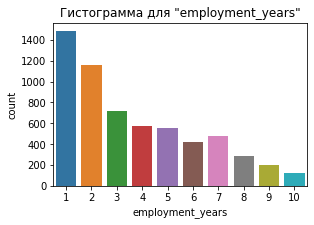

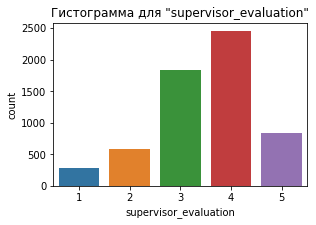

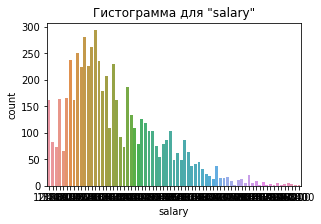

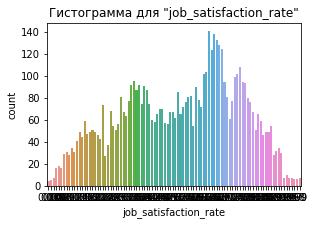

In [25]:
#создадим список наименования столбцов датасета job_satisfaction_rate_df
num_job_satisfaction_rate = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary', 
                  'job_satisfaction_rate']

#построение
for name in num_job_satisfaction_rate:
    boxplot_hist(job_satisfaction_rate_df, name)

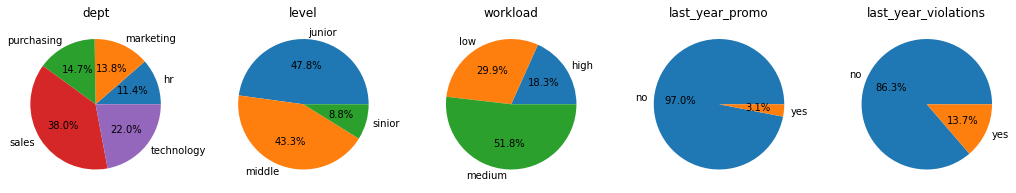

In [26]:
#создадим список наименования столбцов job_satisfaction_rate_df
cat_job_satisfaction_rate = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]    

#построение
i = 1
plt.figure(figsize=(18,3))
for name in cat_job_satisfaction_rate:
    pie_graph(job_satisfaction_rate_df, name, 'id', len(cat_job_satisfaction_rate), i)
    i += 1

- dept — отдел, в котором работает сотрудник: большенство сотрудников работают в отделе продаж - 38%, далее технологи - 22%, отдел закупок - 14,7%, маркетинг - 13,8%, hr - 11,4%

- level — уровень занимаемой должности: большая часть сотрудников junior, далее middle, и небольшой процент senior;

- workload — уровень загруженности сотрудника: чуть больше половины сотрудников имеют средний уровень загруженности;

- employment_years — длительность работы в компании (в годах): судя по гистограмме признак имеет левостороннее распределение, большая часть сотрудников работают около 1-2 года, но есть соотрдники с большим стажем, до 10 лет, средник стаж работы чуть менее 4 лет  - 3,7;

- last_year_promo — показывает, было ли повышение за последний год: всего 3% сотрудников получили повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год, большая часть сотрудников не нарушали трудуовой договор - 86,3%;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель: признак имеет ближе к нормальному распределению, но со смещением вправо, руководители ставят в основном хорошие оценки - 4, средний бал - 3,49;

- salary — ежемесячная зарплата сотрудника: признак скошен влево, имеет несколько пик, средняя зарплата 33973р, минимум получают 12000, максимум - 98400;

- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак: распределение имеет несколько пиков, средний показатель уровня удовлетворенности 0,53 это средний уровень удовлетворенности своей работы сотрудниками.

Рассмотрим связь целевого признака удовлетворенности работы и категориальных признаков

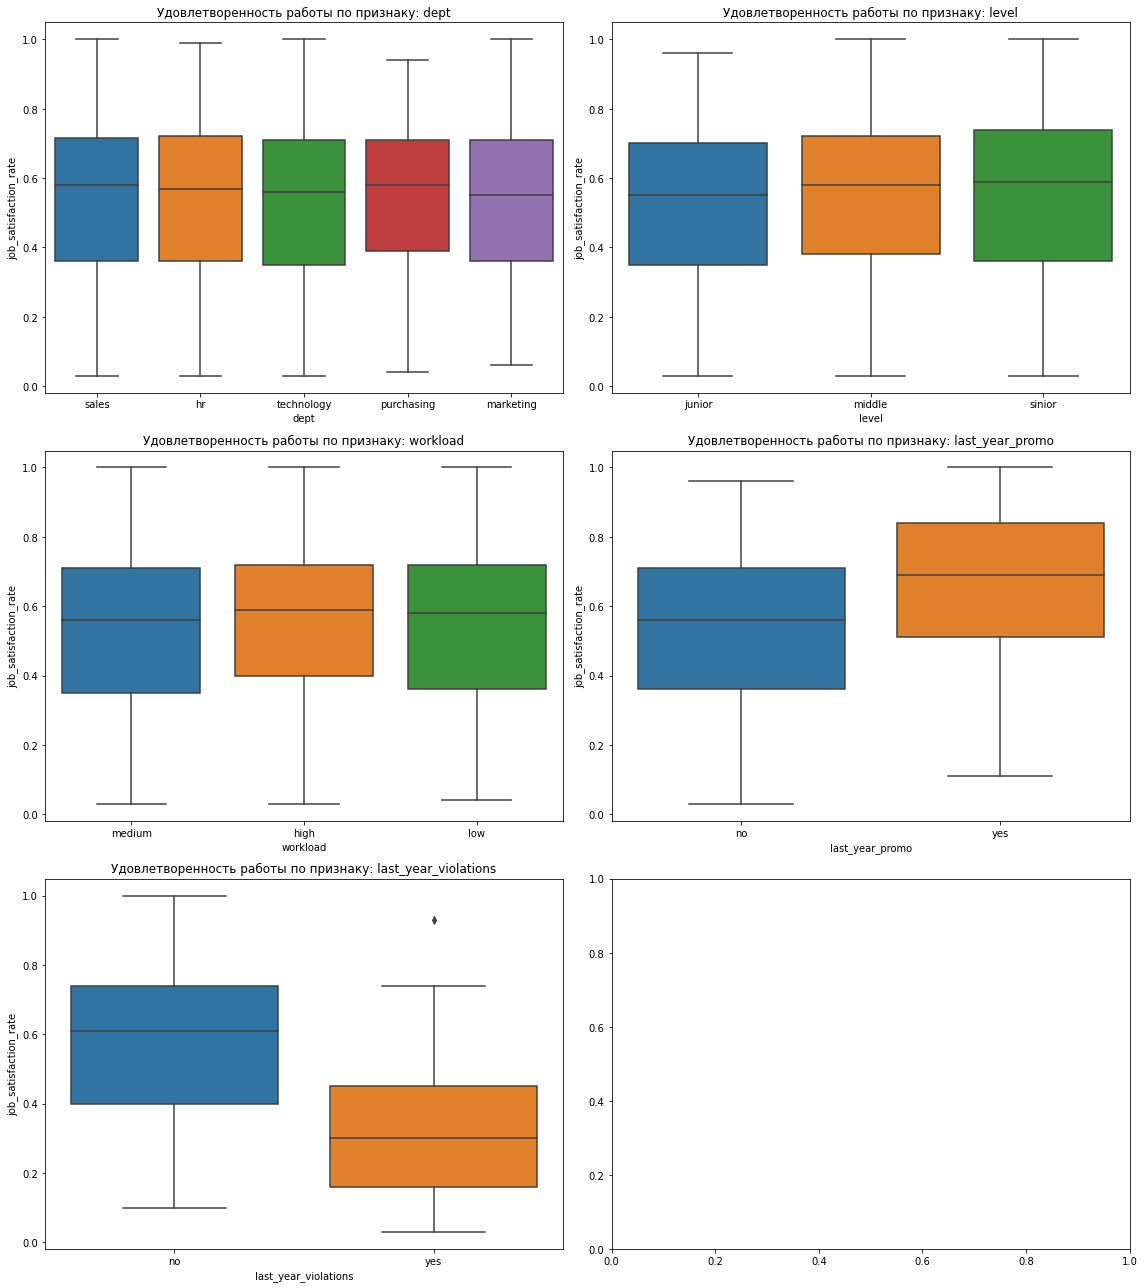

In [27]:
# Визуализация связи между категориальными признаками и удовлетворенностью работы
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()
for i, feature in enumerate(job_satisfaction_rate_df.select_dtypes(include=['object']).columns):
    sns.boxplot(x=feature, y='job_satisfaction_rate', data=job_satisfaction_rate_df, ax=axes[i])
    axes[i].set_title(f'Удовлетворенность работы по признаку: {feature}')
plt.tight_layout()
plt.show()

- dept — отдел, в котором работает сотрудник: в среднем уровень удовлетворенности среди отделов схож, можно выделить, что отделы маркетинга и технологов имеют уровень чуть ниже, чем у остальных;

- level — уровень занимаемой должности: сотрудники junior чуть менее удовлетворены работой, чем middle  и senior;

- workload — уровень загруженности сотрудника: сотрудники, которые средне загружены работой имеют немного меньше уровень, чем остальные категории;

- last_year_promo — показывает, было ли повышение за последний год: сотрудники, которые получили повышение более более удовлетворены работой;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год: сотрудники,кто нарушал трудовой договор менее удовлетворены работой, чем те, кто не нарушал;


In [28]:
job_satisfaction_rate_df.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58


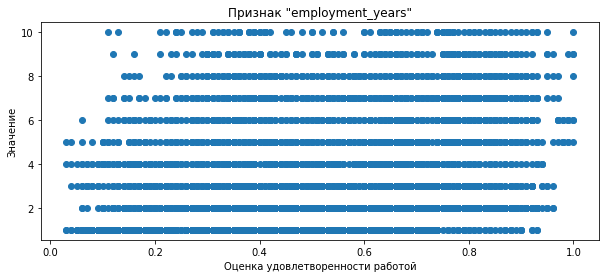

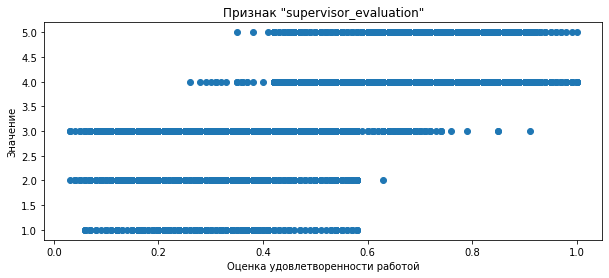

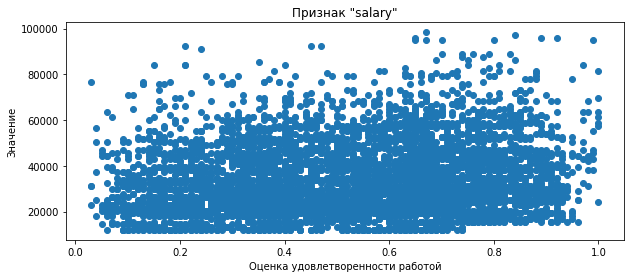

In [29]:
#создадим список наименования столбцов
num_data = ['employment_years',  
            'supervisor_evaluation', 
            'salary', 
]

#построение
for name in num_data:
    plt.figure(figsize=(10, 4))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Оценка удовлетворенности работой')
    plt.ylabel(f'Значение')
    plt.scatter(x=job_satisfaction_rate_df['job_satisfaction_rate'], 
                y=job_satisfaction_rate_df[name])

- employment_years — длительность работы в компании (в годах): можно отметить, что сотрудники работающие около 1-2 лет чаще неудовлетворены работой;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель: сотрудники получающие более высокий бал более удовлетворены работой, чем сотрудники получившие низкие оценки;

- salary — ежемесячная зарплата сотрудника: чем меньше зарплата у сотрудника, тем больше он неудовлетворен своей работой (это логично);


### Промежуточный вывод по разделу:

Удовлетворенность работой в основном зависит от отдела, уровня карьеры, зарплаты, при этом сотрудники с повышениями и без нарушений демонстрируют более высокую удовлетворенность.

### Корреляционный анализ

In [30]:
job_satisfaction_rate_df.corr()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
id,1.000000,-0.014770,0.007080,-0.014510,0.001206
employment_years,-0.014770,1.000000,0.006087,0.464142,0.210528
supervisor_evaluation,0.007080,0.006087,1.000000,0.028258,0.696541
salary,-0.014510,0.464142,0.028258,1.000000,0.136137
job_satisfaction_rate,0.001206,0.210528,0.696541,0.136137,1.000000


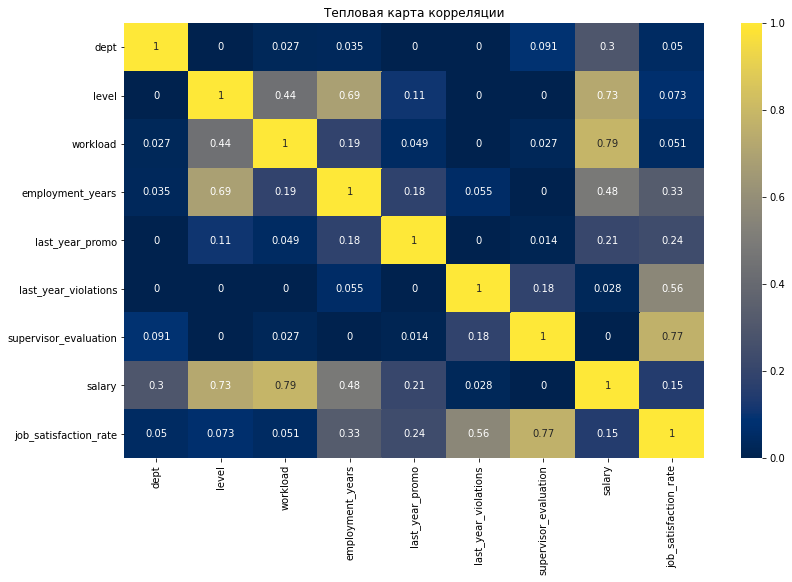

In [31]:
plt.figure(figsize=(13, 8))
sns.heatmap(job_satisfaction_rate_df.drop('id', axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary']), annot=True, cmap='cividis')
plt.title("Тепловая карта корреляции")
plt.show()

Исходя из таблицы можем отметить высокую корреляцию между признаками:
- level и employment_years - 0.69 - чем дольше сотрудник работает, тем выше его уровень;

- level и salary - 0.73 - зарплата напрямую зависит от уровня сотрудника;

- workload и salary - 0.79 - зарплата заивист от нагруженности сотрудника;

- supervisor_evalution и job_satisfaction_rate - 0.77 - уровень удовлетворенности зависит от оценки руководителя.


## Подготовка данных

In [32]:
job_satisfaction_rate_df.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58


In [33]:
#введём обозначения для типов исходных данных:
ohe_columns = [
    'dept',
    'last_year_promo',
    'last_year_violations'
]

ord_columns = [
    'workload',
    'level'
]

num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]    

#разбиение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    job_satisfaction_rate_df.drop(['job_satisfaction_rate', 'id'], axis=1),
    job_satisfaction_rate_df['job_satisfaction_rate'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = job_satisfaction_rate_df['job_satisfaction_rate'])

In [34]:
#разбиение на тренировочную и тестовую выборки
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate'] 
X_test = target_features.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = target_features['job_satisfaction_rate'] 

In [35]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [36]:
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'], 
                    ['junior', 'middle', 'senior'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [37]:
#пайплайн подготовки данных:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [38]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

## Обучение моделей

In [39]:
#перебираем гиперпараметры моделей

param_rs = [
{
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 52),
        'models__min_samples_split': range(1, 52),
        'models__max_features': range(1, 52),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsRegressor()], 
        'models__n_neighbors': range(1, 20),
        'models__weights': ['uniform', 'distance'], 
        'models__algorithm': ['auto', 'brute'], 
        'models__p': [1, 2],  
        'models__metric': ['euclidean', 'manhattan'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
] 


Напишем функцию для новой метрики SMAPE(англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Метрика SMAPE вычисляется так:

SMAPE=100𝑛∑𝑖=1𝑛∣𝑦𝑖−𝑦𝑖^∣(∣𝑦𝑖∣+∣𝑦^𝑖∣)/2,

где:

𝑦𝑖  — фактическое значение целевого признака для объекта с порядковым номером 𝑖 в выборке;

𝑦𝑖^ — предсказанное значение целевого признака для объекта с порядковым номером 𝑖 в выборке;

𝑛 — количество объектов в выборке;

∑𝑖=1𝑛 — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от 𝑖 до 𝑛 в выборке.

In [40]:
def smape(y_true, y_pred):
    n = len(y_true)
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2
    result = np.sum(error / scale)
    smape_value = result * (100 / n)
    return smape_value

In [41]:
metric_smape = make_scorer(smape, greater_is_better=False)

In [42]:
#поиск оптимальной модели с перебором гиперпараметров
rs_cv = RandomizedSearchCV(
    pipe_final,
    param_rs,
    n_iter=50,
    cv=5,
    scoring=metric_smape,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [43]:
#обучение модели на тренировочной выборке
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                         'models__n_neighbors': range(1, 20),
                                         'models__p': [1, 2],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [44]:
print('Лучшая модель и её параметры:\n\n', rs_cv.best_estimator_)
print()
print('Параметры лучшей модели:', rs_cv.best_params_)
print()
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', rs_cv.best_score_*-1)
print()

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [45]:
# Предсказываем значения на тестовой выборке и выводим метрику smape
y_test_pred_job = rs_cv.best_estimator_.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred_job)}')

Метрика SMAPE на тестовой выборке: 13.862183448525014


Результаты других моделей.

In [46]:
result_job = pd.DataFrame(rs_cv.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']]
result_job.mean_test_score = result_job.mean_test_score * -1
result_job = result_job.sort_values(by='rank_test_score')
# Конвертация значений в столбце params в строки
result_job['params'] = result_job['params'].astype(str)
result_job.head(10)

,params,mean_test_score,rank_test_score
27,"{'preprocessor__num': 'passthrough', 'models__...",14.656729,1
21,"{'preprocessor__num': 'passthrough', 'models__...",14.656729,1
45,"{'preprocessor__num': MinMaxScaler(), 'models_...",14.671782,3
3,"{'preprocessor__num': StandardScaler(), 'model...",14.682078,4
13,"{'preprocessor__num': StandardScaler(), 'model...",14.706732,5
0,"{'preprocessor__num': 'passthrough', 'models__...",14.707413,6
35,"{'preprocessor__num': StandardScaler(), 'model...",14.744218,7
15,"{'preprocessor__num': MinMaxScaler(), 'models_...",14.822439,8
37,"{'preprocessor__num': 'passthrough', 'models__...",14.825670,9
2,"{'preprocessor__num': MinMaxScaler(), 'models_...",14.853144,10


### Промежуточный вывод по Задачи №1

Была проведена загрузка, предобработка входных датасетов. Проведен исследовательский анализ, по результату которого можно сказать, что удовлетворенность сотрудниками работой в основном зависит от отдела, уровня карьеры, зарплаты, при этом сотрудники с повышениями и без нарушений демонстрируют более высокую удовлетворенность.

Далее была проведена подготовка данных в пайплане.

Были использованы модели DecisionTreeRegressor, KNeighborsRegressor, LogisticRegression, LinearRegression.

По результату обучения, мы получили параметры лучшей модели DecisionTreeRegressor(random_state=42): {'preprocessor__num': 'passthrough', 'models__min_samples_split': 6, 'models__max_features': 33, 'models__max_depth': 16}

Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 14.505040296991359

Метрика SMAPE на тестовой выборке: 13.304279722363189, что указывает на хорошую способность модели к обобщению и прогнозированию на новых данных.

# Задача №2

## Загрузка данных

Тренировочная выборка:
train_quit.csv
Входные признаки тестовой выборки те же, что и в прошлой задаче:
test_features.csv
Целевой признак тестовой выборки:
test_target_quit.csv

In [47]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
120,490162,purchasing,junior,medium,1,no,no,4,30000,yes
3705,770602,sales,junior,medium,2,no,no,4,21600,no
2807,538080,purchasing,middle,medium,7,no,no,3,44400,no
647,181071,sales,middle,medium,4,no,no,3,42000,no
3838,441766,purchasing,sinior,high,8,no,yes,3,72000,no


In [48]:
test_features_2 = pd.read_csv('/datasets/test_features.csv')
test_features_2.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
516,385270,purchasing,middle,high,1,no,no,4,55200
662,464449,purchasing,junior,medium,2,no,no,4,30000
798,145247,marketing,middle,medium,1,no,no,4,40800
1737,175029,purchasing,middle,high,9,no,no,4,60000
1052,180969,technology,junior,medium,2,no,no,4,31200


In [49]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.sample(5)

,id,quit
491,100480,no
232,923415,yes
1529,866216,no
139,945189,no
143,891609,no


### Промежуточный выводк разделу

Произвели загрузку данных из локальных дисков:

- train_quit.csv

- test_features.csv

- test_target_quit.csv

Датасет test_features_2 идентичен датасету test_features из первой задачи.

На первый взгляд наименование столбцов корректно, приведены к нижнему змеиному регистру.

Исходя из приложенной документации опишем признаки:

- id — уникальный идентификатор сотрудника;

- dept — отдел, в котором работает сотрудник;

- level — уровень занимаемой должности;

- workload — уровень загруженности сотрудника;

- employment_years — длительность работы в компании (в годах);

- last_year_promo — показывает, было ли повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

- salary — ежемесячная зарплата сотрудника;

- quit — уволился сотрудник, целевой признак.

## Предобработка данных.

In [50]:
#изучим датасат train_quit
print('Размерность датасета:', train_quit.shape)
print()
print(train_quit.info())
print()
print('Количество дубликатов:', train_quit.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', train_quit.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', train_quit['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',train_quit['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',train_quit['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',train_quit['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',train_quit['last_year_promo'].unique())
print()
print('Уникальные значения колонки "quit":', '\n',train_quit['quit'].unique())

Размерность датасета: (4000, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years    

#### Промежуточный вывод к train_quit

В датасете train_quit имеем 10 колонок, 4000 строк. Явных и неявных дубликатов нет. Наименование колонок корректно. Пропусков нет.

In [51]:
#изучим датасат test_features_2
print('Размерность датасета:', test_features_2.shape)
print()
print(test_features_2.info())
print()
print('Количество дубликатов:', test_features_2.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', test_features_2.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', test_features_2['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',test_features_2['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',test_features_2['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',test_features_2['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',test_features_2['last_year_promo'].unique())

Размерность датасета: (2000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violation

In [52]:
#взглянем на строки с пропусками в колонке dept
test_features_2[(test_features_2['dept'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [53]:
#взглянем на строки с пропусками в колонке level
test_features_2[(test_features_2['level'].isna())]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [54]:
#взглянем на строки с пробелами в колонке dept
test_features_2[(test_features_2['dept'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [55]:
#взглянем на строки с пробелами в колонке workload
test_features_2[(test_features_2['workload'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [56]:
test_features_2['workload'].replace(' ', np.nan, inplace=True)
test_features_2['dept'].replace(' ', np.nan, inplace=True)
print('Уникальные значения колонки "workload":', '\n',test_features_2['workload'].unique())
print()
print('Уникальные значения колонки "dept":', '\n', test_features_2['dept'].unique())
print()
print('Количество пропусков в колонках:', '\n', test_features_2.isna().sum())

Уникальные значения колонки "workload": 
 ['medium' 'low' 'high' nan]

Уникальные значения колонки "dept": 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]

Количество пропусков в колонках: 
 id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


#### Промежуточный результат к test_features_2

В датасете test_features_2 имеем 9 колонок, 2000 строк. Явных и неявных дубликатов нет. Наименование колонок корректно. Имеются пропуски в колонках dept(отдел, в котором работает сотрудник) - 2шт. Колонка level(уровень занимаемой должности) - 1шт. Используем метод SimpleImputer с параметром strategy='most_frequent' для заполнения пропусков на этапе создание пайплана.

In [57]:
#изучим датасат test_target_quit
print('Размерность датасета:', test_target_quit.shape)
print()
print(test_target_quit.info())
print()
print('Количество дубликатов:', test_target_quit.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', test_target_quit.isna().sum())
print()
print('Уникальные значения колонки "quit":', '\n', test_target_quit['quit'].unique())


Размерность датасета: (2000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None

Количество дубликатов: 0

Количество пропусков в колонках: 
 id      0
quit    0
dtype: int64

Уникальные значения колонки "quit": 
 ['yes' 'no']


#### Промежуточный результат к test_target_quit

В датасете test_target_job_satisfaction_rate имеем 2 колонки, 2000 строк. Явных и неявных дубликатов нет. Пропусков нет. Наименование колонок корректно.

### Промежуточный вывод к разделу

Были изучены полученные датасеты:

типы данных в датасетах соответсвуют;

наименование колонок корректны;

были замечены пробелы в данных, принято решение заменить их на nan;

были замечены пропуски в данных, принято решение используя метод SimpleImputer с параметром strategy='most_frequent' заполнить на этапе создание пайплана;

Описание признаков:

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;
quit — показывает, уволился ли сотрудник или нет.

## Исследовательский анализ данных

Для проведения исследовательсокого анализа соберем все датасеты в один. Объеденим датасеты test_target_quit и test_features_2 по общей колонке id. Далее добавим поленую таблицу к датасету train_quit.

In [58]:
#объеденим датасеты test_features_2 и test_target_quit по колонке id
target_features_2 = test_features_2.merge(test_target_quit, on = 'id', how = 'left')

#проверим
print(target_features_2.head(2))
target_features_2.info()

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      5   28800   no  
1                   no                      4   30000   no  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluatio

In [59]:
#добавим к датасету train_quit полученный датасет target_features_2
quit_df = pd.concat([train_quit, target_features_2])

#проверим что получилось
print(quit_df.head(2))
print()
print('Размерность датасета:', quit_df.shape)
print()
print(quit_df.info())
print()
print('Количество дубликатов:', quit_df.duplicated().sum())
print()
print('Количество пропусков в колонках:', '\n', quit_df.isna().sum())
print()
print('Уникальные значения колонки "dept":', '\n', quit_df['dept'].unique())
print()
print('Уникальные значения колонки "level":', '\n',quit_df['level'].unique())
print()
print('Уникальные значения колонки "workload":', '\n',quit_df['workload'].unique())
print()
print('Уникальные значения колонки "last_year_violations":', '\n',quit_df['last_year_violations'].unique())
print()
print('Уникальные значения колонки "last_year_promo":', '\n',quit_df['last_year_promo'].unique())
print()
print('Уникальные значения колонки "quit":', '\n',quit_df['quit'].unique())

       id   dept   level workload  employment_years last_year_promo  \
0  723290  sales  middle     high                 2              no   
1  814010  sales  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  

Размерность датасета: (6000, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6000 non-null   int64 
 1   dept                   5997 non-null   object
 2   level                  5999 non-null   object
 3   workload               5999 non-null   object
 4   employment_years       6000 non-null   int64 
 5   last_year_promo        6000 non-null   object
 6   last_year_violations   6000 non-null   object
 7

Функции для построения диаграмм написана ранее.

Описательная статистика признака: employment_years 
 count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
Описательная статистика признака: supervisor_evaluation 
 count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
Описательная статистика признака: salary 
 count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


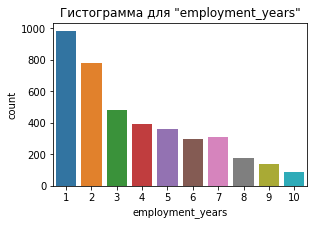

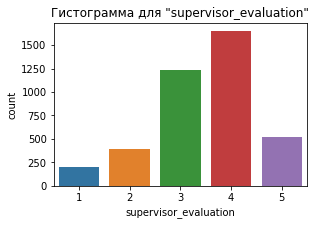

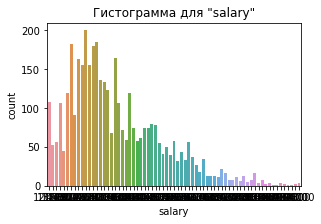

In [60]:
#создадим список наименования столбцов датасета train_quit
num_train_quit = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary']

#построение
for name in num_train_quit:
    boxplot_hist(train_quit, name)

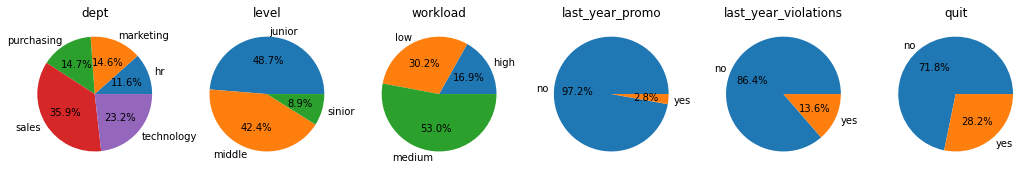

In [61]:
#создадим список наименования столбцов train_quit
cat_train_quit = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'quit'
]  

#построение
i = 1
plt.figure(figsize=(18,3))
for name in cat_train_quit:
    pie_graph(train_quit, name, 'id', len(cat_train_quit), i)
    i += 1

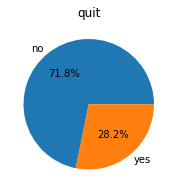

In [62]:
#создадим список наименования столбцов test_target_quit
cat_test_target_quit = ['quit']  

#построение
i = 1
plt.figure(figsize=(18,3))
for name in cat_test_target_quit:
    pie_graph(test_target_quit, name, 'id', len(cat_test_target_quit), i)
    i += 1

In [63]:
#создадим список наименования столбцов датасета quit_df
num_quit = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary']

Описательная статистика признака: employment_years 
 count    6000.000000
mean        3.689833
std         2.540152
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
Описательная статистика признака: supervisor_evaluation 
 count    6000.000000
mean        3.492000
std         1.001883
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
Описательная статистика признака: salary 
 count     6000.000000
mean     33892.800000
std      15234.077185
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


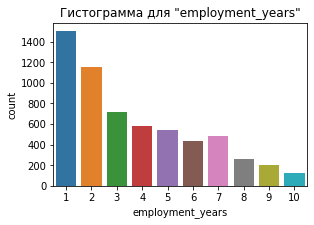

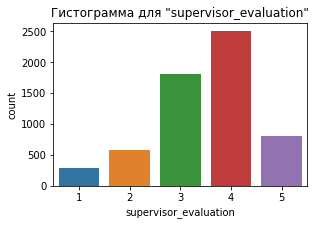

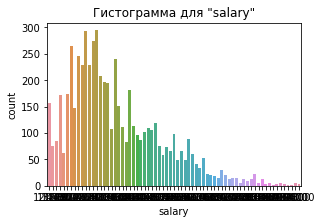

In [64]:
#построение
for name in num_quit:
    boxplot_hist(quit_df, name)

In [65]:
#создадим список наименования столбцов train_job_satisfaction_rate
cat_quit = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'quit'
]  

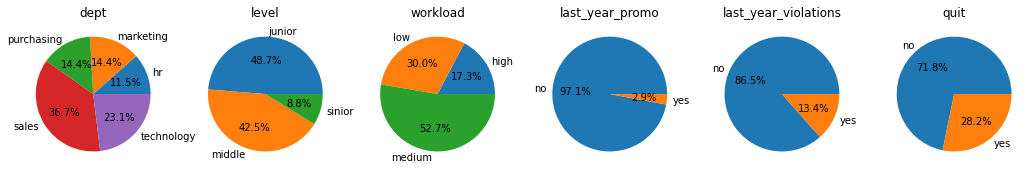

In [66]:
#построение
i = 1
plt.figure(figsize=(18,3))
for name in cat_quit:
    pie_graph(quit_df, name, 'id', len(cat_quit), i)
    i += 1

dept — отдел, в котором работает сотрудник: большенство сотрудников работают в отделе продаж - 36,7%, далее технологи - 23,1%, отдел закупок - 14,4%, маркетинг - 14,4%, hr - 11,5%

level — уровень занимаемой должности: большая часть сотрудников junior, далее middle, и небольшой процент senior;

workload — уровень загруженности сотрудника: чуть больше половины сотрудников имеют средний уровень загруженности;

employment_years — длительность работы в компании (в годах): судя по гистограмме признак имеет левостороннее распределение, большая часть сотрудников работают около 1-2 года, но есть соотрдники с большим стажем, до 10 лет, средник стаж работы чуть менее 4 лет - 3,7;

last_year_promo — показывает, было ли повышение за последний год: всего 3% сотрудников получили повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год, большая часть сотрудников не нарушали трудуовой договор - 86,3%;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель: признак имеет ближе к нормальному распределению, но со смещением вправо, руководители ставят в основном хорошие оценки - 4, средний бал - 3,49;

salary — ежемесячная зарплата сотрудника: признак скошен влево, имеет несколько пик, средняя зарплата 33973р, минимум получают 12000, максимум - 98400;

quit — соотношение уволившихся собтрудников к не уволившимся 28,2% - уволившиеся, 71,8% работают.

Рассмотрим признаки относительно целевого quit

In [67]:
#создание функции для построения гистограммы диаграммы размаха для количественных признаков

def boxplot_hist_1(dataset, column):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{column}"')
    sns.kdeplot(data=dataset, x=column, hue='quit')
    plt.xlabel(f'Значение параметра "{column}"')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x='quit', y=column, data=dataset);
    plt.ylabel(f'Значение параметра "{column}"')
    
    
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph_1(dataset, column):
    plt.figure(figsize=(15,3))
    plt.subplot(1, 2, 1)
    plt.title(f'Признак "{column}"\n Сотрудник уволился')
    plt.pie(x=dataset[dataset['quit']=='yes'].groupby(column)['id'].count(),
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index)
    plt.subplot(1, 2, 2)
    plt.title(f'Признак "{column}"\n Сотрудник продолжает работает')
    plt.pie(x=dataset[dataset['quit']!='yes'].groupby(column)['id'].count(),
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index) 

In [68]:
#создадим список наименования столбцов датасета quit_df
num_quit_1 = ['employment_years', 
                  'supervisor_evaluation', 
                  'salary']

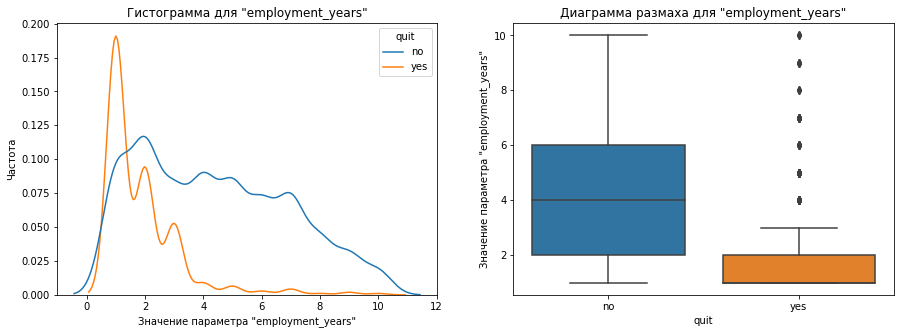

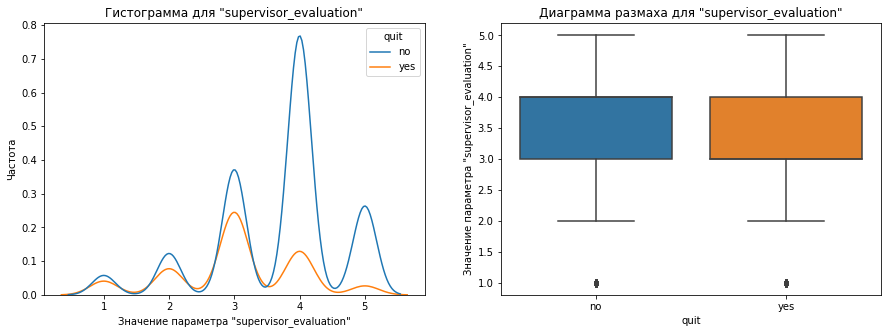

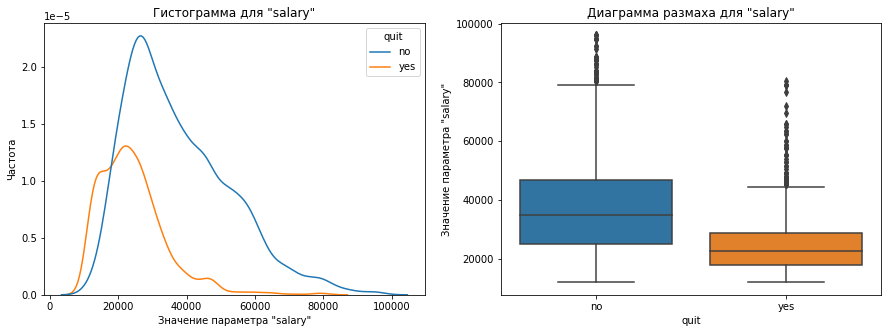

In [69]:
#построение
for name in num_quit_1:
    boxplot_hist_1(quit_df, name)

In [70]:
#создадим список наименования столбцов quit_df
cat_quit_1 = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
] 

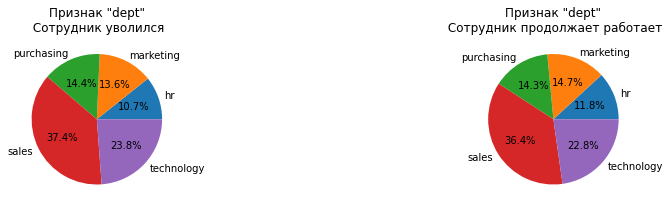

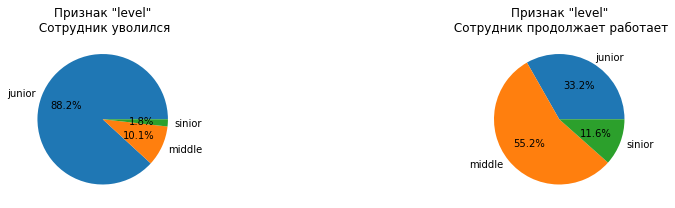

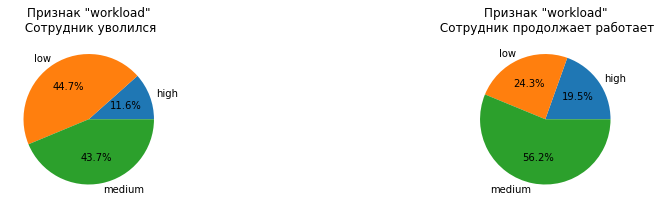

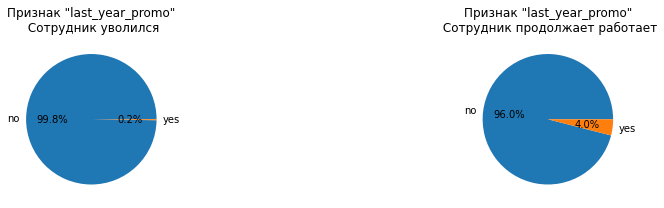

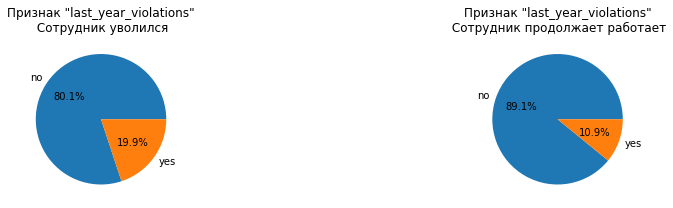

In [71]:
#построение

for name in cat_quit_1:
    pie_graph_1(quit_df, name)

Рассмотрим доли уволившихся сотрудников относительно категориального признака

In [72]:
def fraction(data, column):
    w = data.groupby(column)['id'].count()
    q = data.query('quit != "no"').groupby(column)['id'].count()
    print('Доля уволившихся сотрудников',  round(q / w, 2))
    

In [73]:
column_quit_df = ['dept', 'level', 'workload', 'last_year_violations', 'last_year_promo']

In [74]:
for name in column_quit_df:
    fraction(quit_df, name)

Доля уволившихся сотрудников dept
hr            0.26
marketing     0.27
purchasing    0.28
sales         0.29
technology    0.29
Name: id, dtype: float64
Доля уволившихся сотрудников level
junior    0.51
middle    0.07
sinior    0.06
Name: id, dtype: float64
Доля уволившихся сотрудников workload
high      0.19
low       0.42
medium    0.23
Name: id, dtype: float64
Доля уволившихся сотрудников last_year_violations
no     0.26
yes    0.42
Name: id, dtype: float64
Доля уволившихся сотрудников last_year_promo
no     0.29
yes    0.02
Name: id, dtype: float64


dept — отдел, в котором работает сотрудник: относительно отдела - большого расхождения между отделами относительно уволившимися и работающими сотрудниками нет

level — уровень занимаемой должности: большая часть сотрудников junior - уволились, далее middle, и небольшой процент senior; относительно сотрудников, которые продолжают работать немного другая ситуация, больший процент имеют middle, далее junior, далее senior;

workload — уровень загруженности сотрудника: касательно загрузки работников то у уволившихся сотрудников больше была низкая нагрузка, у работающих же это средний уровень;

employment_years - длительность работы в компании (в годах): — большая часть сотрудников увольняется на первых годах рабоаты;

last_year_promo — показывает, было ли повышение за последний год: касательно повышения можно сказать что разницы большой нет, у обоих групп низкий процент положительного ответа, правда у сотрудников которые продолжают работать он все таки повыше;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год, уволившиеся сотрудники немного чаще нарушали трудуовой договор;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель: в среднем одинаково влияет на останется ли сотрдуник или  уволиться;

salary — ежемесячная зарплата сотрудника: по диаграмме видно, что у уволившихся сотрудников зарплата меньше, чем у оставшихся работать;


Исходя из полученных данных можно составить портрет сотрудника, который уволился:

Как правило увольняются сотрудники, которые только начинают свой карьерный путь, в статусе junior. Скорее всего эти сотрудники планировали за короткий срок подняться по карьерной лестнице, как минимум на этап выше, но повышения не случилось. В следствии чего у таких сотрудников остался низкий уровень заработной платы, что в свою очередь сильной мотивацией уволиться или продолжать работать. Причем особой разницы нет в каком отделе работает сотрудник.
Так же можно выделить, что относительно отделов доля уволившихся сотрудников к общему числу примерно одинкова - 0.26...0.29.
Чего не скажешь относительно признака level. Здесь статус junior лидирует в этом отношении - 0.51, в тоже время как остальные 0.06...0.07.

Другими словами, сотрудники имеющие низкий доход, не получившие поввышения на первых годах работы будут более склонны к увольнению.

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. 
Проверим это утверждение. Визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

In [75]:
full_data = job_satisfaction_rate_df.merge(quit_df[['id', 'quit']], on='id')
full_data.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no


In [76]:
col_quit = ['job_satisfaction_rate']

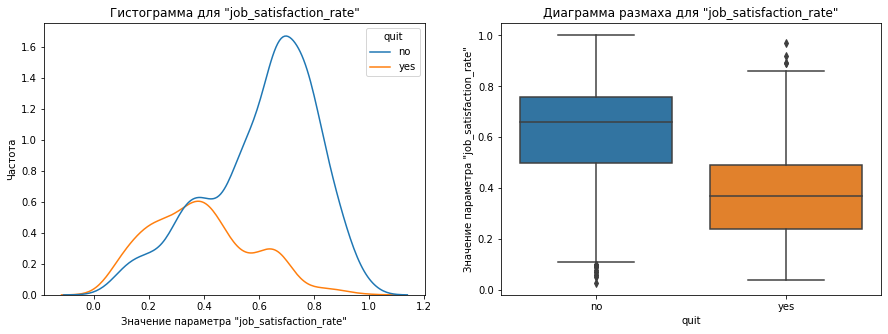

In [77]:
#построение
for name in col_quit:
    boxplot_hist_1(full_data, name)

In [78]:
quit_yes = full_data[full_data['quit'] == 'yes']
quit_no = full_data[full_data['quit'] == 'no']

In [79]:
quit_yes['job_satisfaction_rate'].describe()

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

In [80]:
quit_no['job_satisfaction_rate'].describe()

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Действительно, можно сказать, что уровень удовлетворенности сотрудника работой влияет на его решение уволиться или продолжать работать в компании. Так Средний уровень удовлетворенности работой у сотрудников которые уволились - 0.38, а у сотрудников, которые продолжают трудиться - 0.61, т.е. чуть меньше чем в 2 раза.

### Корреляционный анализ данных

In [81]:
quit_df.corr()

,id,employment_years,supervisor_evaluation,salary
id,1.000000,0.026689,-0.004340,0.003869
employment_years,0.026689,1.000000,0.004232,0.467506
supervisor_evaluation,-0.004340,0.004232,1.000000,0.054229
salary,0.003869,0.467506,0.054229,1.000000


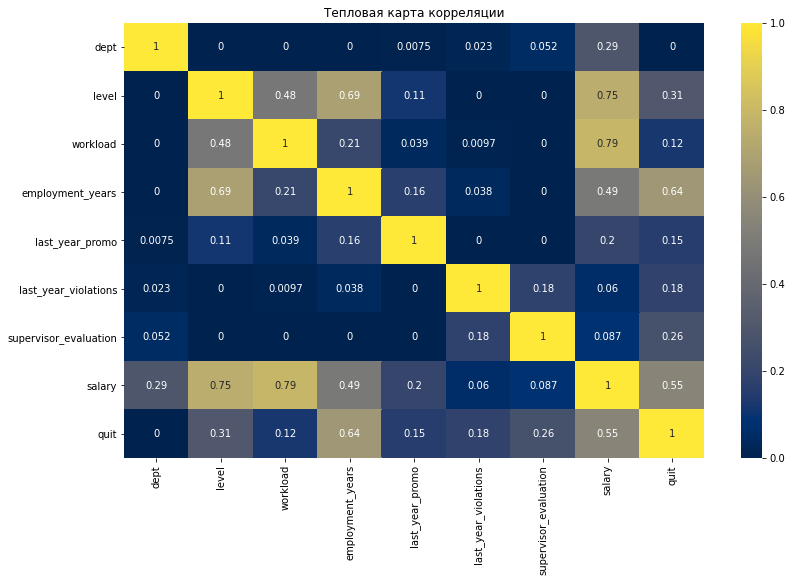

In [82]:
plt.figure(figsize=(13, 8))
sns.heatmap(quit_df.drop('id', axis=1).phik_matrix(interval_cols=['salary']), annot=True, cmap='cividis')
plt.title("Тепловая карта корреляции")
plt.show()

Исходя из таблицы можем отметить высокую корреляцию между признаками:

- level и employment_years - 0.69 - чем дольше сотрудник работает, тем выше его уровень;

- level и salary - 0.75 - зарплата напрямую зависит от уровня сотрудника;

- employment_years и quit - 0.64 - длительность работы в компании и увольнение сотрудника

- workload и salary - 0.79 - зарплата заивист от нагруженности сотрудника;

- supervisor_evalution и job_satisfaction_rate - 0.77 - уровень удовлетворенности зависит от оценки руководителя.

## Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью.

In [83]:
quit_df['job_satisfaction_rate'] = rs_cv.best_estimator_.predict(quit_df)

In [84]:
quit_df.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.618000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [85]:
quit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6000 non-null   int64  
 1   dept                   5997 non-null   object 
 2   level                  5999 non-null   object 
 3   workload               5999 non-null   object 
 4   employment_years       6000 non-null   int64  
 5   last_year_promo        6000 non-null   object 
 6   last_year_violations   6000 non-null   object 
 7   supervisor_evaluation  6000 non-null   int64  
 8   salary                 6000 non-null   int64  
 9   quit                   6000 non-null   object 
 10  job_satisfaction_rate  6000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 691.5+ KB


## Подготовка данных

In [97]:
#введём обозначения для типов исходных данных:
ohe_columns_1 = [
    'dept',
    'last_year_promo',
    'last_year_violations'
]

ord_columns_1 = [
    'workload',
    'level'
]

num_columns_1 = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]   

In [98]:
#разбиение на тренировочную и тестовую выборки
X_train_1 = train_quit.drop(['quit', 'id'], axis=1)
y_train_1 = train_quit['quit'] 
X_test_1 = target_features_2.drop(['quit', 'id'], axis=1)
y_test_1 = target_features_2['quit'] 

In [99]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train_1 = label_encoder.fit_transform(y_train_1)
y_test_1 = label_encoder.transform(y_test_1)

In [100]:
# SimpleImputer + OHE
ohe_pipe_1 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [101]:
# SimpleImputer + ORD
ord_pipe_1 = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'], 
                    ['junior', 'middle', 'senior'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [102]:
#пайплайн подготовки данных:
data_preprocessor_1 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_1, ohe_columns_1),
        ('ord', ord_pipe_1, ord_columns_1),
        ('num', StandardScaler(), num_columns_1)
    ], 
    remainder='passthrough'
) 

In [103]:
# итоговый пайплайн: подготовка данных и модель
pipe_final_1 = Pipeline(
    [
        ('preprocessor', data_preprocessor_1),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

## Обучение модели

In [104]:
#перебираем гиперпараметры моделей

param_random = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['rbf', 'sigmold', 'linear'],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
        {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': ['passthrough'],
        'models__n_estimators': range(50, 301, 50),
        'models__max_depth': range(8,21,3)
    }
] 

In [105]:
#поиск оптимальной модели с перебором гиперпараметров
random_search_1 = RandomizedSearchCV(
    pipe_final_1,
    param_random,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

#обучение модели на тренировочной выборке
random_search_1.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                        {'models': [SVC(random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__kernel': ['rbf', 'sigmold',
                                                            'linear'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': range(8, 21, 3),
                                         'models__n_estimators': range(50, 301, 50),
                                         'preprocessor__num': ['passthrough']}],
                   scoring='roc_auc')

In [106]:
print('Метрика roc_auc для лучшей модели:\n', random_search_1.best_score_)
print('\nЛучшая модель и её параметры:\n\n', random_search_1.best_estimator_)

Метрика roc_auc для лучшей модели:
 0.9366324941738068

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                    

In [107]:
# проверим работу модели на тестовой выборке
probabilities = random_search_1.predict_proba(X_test_1)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test_1, probabilities_one))

Площадь ROC-кривой: 0.9295144856674371


In [108]:
result = pd.DataFrame(random_search_1.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(5))

   rank_test_score                             param_models  mean_test_score  \
1                1  RandomForestClassifier(random_state=42)         0.936632   
3                2                     SVC(random_state=42)         0.921185   
8                3                     SVC(random_state=42)         0.920555   
0                4                   KNeighborsClassifier()         0.908476   
6                5                   KNeighborsClassifier()         0.907445   

                                              params  
1  {'preprocessor__num': 'passthrough', 'models__...  
3  {'preprocessor__num': StandardScaler(), 'model...  
8  {'preprocessor__num': StandardScaler(), 'model...  
0  {'preprocessor__num': MinMaxScaler(), 'models_...  
6  {'preprocessor__num': 'passthrough', 'models__...  


### Промежуточный вывод к разделу

Была проведена загрузка, предобработка входных датасетов. Проведен исследовательский анализ, исходя из полученных данных можно составить портрет сотрудника, который уволился:

Как правило увольняются сотрудники, которые только начинают свой карьерный путь, в статусе junior. Скорее всего эти сотрудники планировали за короткий срок подняться по карьерной лестнице, как минимум на этап выше, но повышения не случилось. В следствии чего у таких сотрудников остался низкий уровень заработной платы, что в свою очередь сильной мотивацией уволиться или продолжать работать. Причем особой разницы нет в каком отделе работает сотрудник.

Другими словами, сотрудники имеющие низкий доход, не получившие поввышения на первых годах работы будут более склонны к увольнению.

Так же отметим, что действительно, можно сказать, что уровень удовлетворенности сотрудника работой влияет на его решение уволиться или продолжать работать в компании. Так Средний уровень удовлетворенности работой у сотрудников которые уволились - 0.38, а у сотрудников, которые продолжают трудиться - 0.61, т.е. чуть меньше чем в 2 раза.

Далее была проведена подготовка данных в пайплане. 
 
Были использованы модели: KNeighborsClassifier, DecisionTreeClassifier, SVC, RandomForestClassifier.

По результату обучения, мы получили параметры лучшей модели RandomForestClassifier(max_depth=8, n_estimators=250, random_state=42)

Метрика ROC AUC лучшей модели: 0.9300121275320017

Метрика ROC-кривой на тестовой выборке: 0.9507135002008468

## Общий вывод

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Поставлены 2 задачи:

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Были проведены следующие этапы работы:

- Загрузка данных:
Получены датасеты со следующими признаками:

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

- Предобработка данных
Были изучены полученные датасеты:

типы данных в датасетах соответсвуют;

наименование колонок корректны;

были замечены пробелы в данных, принято решение заменить их на nan;

были замечены пропуски в данных, принято решение используя метод SimpleImputer с параметром strategy='most_frequent' заполнить на этапе создание пайплана;


- Исследовательский анализ данных
Проведен исследовательский анализ, по результату которого можно сказать, что удовлетворенность сотрудниками работой в основном зависит от отдела, уровня карьеры, зарплаты, при этом сотрудники с повышениями и без нарушений демонстрируют более высокую удовлетворенность.

Можно составить портрет сотрудника, который уволился:

Как правило увольняются сотрудники, которые только начинают свой карьерный путь, в статусе junior. Скорее всего эти сотрудники планировали за короткий срок подняться по карьерной лестнице, как минимум на этап выше, но повышения не случилось. В следствии чего у таких сотрудников остался низкий уровень заработной платы, что в свою очередь сильной мотивацией уволиться или продолжать работать. Причем особой разницы нет в каком отделе работает сотрудник.

Другими словами, сотрудники имеющие низкий доход, не получившие поввышения на первых годах работы будут более склонны к увольнению.

Так же отметим, что действительно, можно сказать, что уровень удовлетворенности сотрудника работой влияет на его решение уволиться или продолжать работать в компании. Так Средний уровень удовлетворенности работой у сотрудников которые уволились - 0.38, а у сотрудников, которые продолжают трудиться - 0.61, т.е. чуть меньше чем в 2 раза.

- Подготовка данных и обучение моделей:
Задача №1
Была проведена подготовка данных в пайплане.

Были использованы модели DecisionTreeRegressor, KNeighborsRegressor, LinearRegression.

По результату обучения, мы получили параметры лучшей модели DecisionTreeRegressor(random_state=42): {'preprocessor__num': 'passthrough', 'models__min_samples_split': 6, 'models__max_features': 33, 'models__max_depth': 16}

Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 14.505040296991359

Метрика SMAPE на тестовой выборке: 13.304279722363189, что указывает на хорошую способность модели к обобщению и прогнозированию на новых данных.

Задача №2

Была проведена подготовка данных в пайплане.

Были использованы модели: KNeighborsClassifier, DecisionTreeClassifier, SVC, RandomForestClassifier.

По результату обучения, мы получили параметры лучшей модели RandomForestClassifier(max_depth=8, n_estimators=250, random_state=42)

Метрика ROC AUC лучшей модели: 0.9300121275320017

Метрика ROC-кривой на тестовой выборке: 0.9507135002008468

- Вывод и рекоминдации

Достигнута высокая точность предсказаний, что подтверждает возможность использования данных моделей в реальных бизнес-процессах.

Предлагается использовать модели машинного обучения для предсказаний удовлетворенности работой сотрудников, и возможностью заблаговременно реагировать на возможные уволенния.

Стоит уделить внимание сотрудникам начинающим работать в организации(стаж работы около года). Возможно увеличить уровень нагрузки на сотрудника, с возможностью увеличения дохода, и возможности проявить себя, для ускоренного прохождения по карьерной лестнице. Разработать систему лаяльности к сотрудникам, с возможностью доп. премирований.